<a href="https://colab.research.google.com/github/udAAbu/JSL_Project/blob/main/Multi_tasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Tasking CNN Model
- predict **KL_grade** and **Joint space loss** at the same time.
- expect the CNN to learn more fruitful features.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import time
import os
import copy
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

plt.ion()
pd.set_option("display.max_colwidth", None)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Joint space loss CSV file
JSL_path = "/content/drive/MyDrive/OAI_data/JSL.csv"
Image_dir = "/content/drive/MyDrive/OAI_data/complete_images/"

In [5]:
JSL_data = pd.read_csv(JSL_path)
available_images = os.listdir(Image_dir)

JSL_data['Img_id'] = JSL_data.apply(lambda x: x['ID'] + '.png', axis = 1)
JSL_data["Img_path"] = JSL_data.apply(lambda x: Image_dir + x['Img_id'], axis = 1)

#filter out those records without label or without images
table = JSL_data[(JSL_data['Img_id'].isin(available_images)) & (JSL_data['JSL_Prog'].isna() == False)]
table.head()

,ID,Age,Sex,BMI,Race,BL_KL_grade,Knee_Injury,Alignmnet_TRIN,Alignment_degree,JSL_Prog,Img_id,Img_path
0,9001897_1,72,1,25.9,1.0,3.0,1.0,1.0,6.0,1.0,9001897_1.png,/content/drive/MyDrive/OAI_data/complete_images/9001897_1.png
1,9002116_1,61,1,36.5,2.0,2.0,0.0,1.0,4.0,1.0,9002116_1.png,/content/drive/MyDrive/OAI_data/complete_images/9002116_1.png
2,9003380_2,64,1,33.1,1.0,1.0,0.0,1.0,5.0,1.0,9003380_2.png,/content/drive/MyDrive/OAI_data/complete_images/9003380_2.png
3,9004905_2,66,2,36.2,2.0,2.0,0.0,2.0,-3.0,1.0,9004905_2.png,/content/drive/MyDrive/OAI_data/complete_images/9004905_2.png
4,9009957_1,75,2,26.8,1.0,2.0,0.0,0.0,0.0,1.0,9009957_1.png,/content/drive/MyDrive/OAI_data/complete_images/9009957_1.png


In [64]:
def train_val_test(table, test_size, val_size, balance = True):
    if balance:
        balanced_table = pd.concat([table[table['JSL_Prog'] == 0].sample(frac = 0.5), table[table['JSL_Prog'] == 1]])
        print(balanced_table['JSL_Prog'].value_counts())

        X_train, X_test, y_train, y_test = train_test_split(balanced_table.drop(columns = 'JSL_Prog'), balanced_table[['BL_KL_grade', 'JSL_Prog']], test_size = test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    else:
        X_train, X_test, y_train, y_test = train_test_split(table.drop(columns = 'JSL_Prog'), table[['BL_KL_grade', 'JSL_Prog']], test_size = test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [65]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(table, test_size = 400, val_size = 400, balance = True)

data_dict = {"train": {'images': X_train, 'labels': y_train},
            'val': {'images': X_val, 'labels': y_val}, 
            'test': {'images': X_test, 'labels': y_test}}

0.0    1406
1.0    1351
Name: JSL_Prog, dtype: int64


### Dataset and DataLoader

In [14]:
class MultiTaskDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.images = df['Img_path'].tolist()
        self.labels = labels.values
        self.transform = transform

    def __len__(self): 
        return len(self.images)

    def __getitem__(self,idx):
        #dealing with the image
        img = Image.open(self.images[idx]).convert('RGB')

        if self.transform:
            img = self.transform(img)

        KL_grade, prog_label = self.labels[idx]
        KL_grade, prog_label = torch.tensor(KL_grade, dtype = torch.int64), torch.tensor(prog_label, dtype = torch.int64)
        return img, (KL_grade, prog_label)

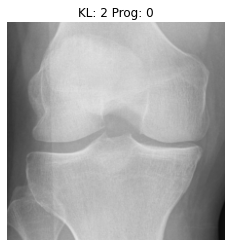

In [27]:
train_dataset = MultiTaskDataset(X_train, y_train, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]))

temp_img, temp_lab = train_dataset[10]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(str("KL: " + str(temp_lab[0].item()) + " Prog: " + str(temp_lab[1].item())))
plt.axis('off')
plt.show()

In [29]:
def imshow(inp, title=None, unnormalize = False):
    """
    Helper function to visualize one batch of image tensor
    """
    inp = inp.numpy().transpose((1, 2, 0))

    if unnormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    plt.imshow(inp, cmap = plt.cm.bone)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [36]:
def load_data(data, normalize = False, show_images = True):
    """
    loading data into dataloaders
    
    data: the dictionary that contains all the train/val/test
    normalize: whether to normalize image by ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    show_images: whether to show one batch of images
    """
    if normalize:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
    else:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
        }
    
    image_datasets = {x: MultiTaskDataset(data[x]['images'], data[x]['labels'], data_transforms[x]) \
                      for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) \
                   for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    if show_images:
        if normalize == True:
            # Get a batch of training data
            img_inputs, classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[x for x in classes], unnormalize = True)
        else:
            # Get a batch of training data
            img_inputs, classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[x for x in classes])

    return dataloaders, dataset_sizes, image_datasets

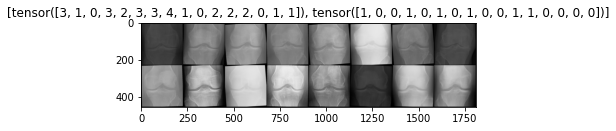

In [67]:
dataloaders, dataset_sizes, image_datasets = load_data(data_dict, normalize = False, show_images=True)

### Define the Multi-Tasking Model

In [47]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = models.vgg16(pretrained = True)
        self.cnn.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.cnn.classifier = nn.Sequential(nn.Flatten())

        self.fc1 = nn.Sequential(
            nn.Linear(512, 5),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 1),
        )

    def forward(self, image):
        feature = self.cnn(image)
        KL = self.fc1(feature)
        Prog = self.fc2(feature)
        return KL, Prog
        
def get_model():

    model_ft = MyModel()

    criterion1 = nn.CrossEntropyLoss()
    criterion2 = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model_ft.parameters(), lr = 0.0001)

    # Decay LR by a factor of 0.1 every 3 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose = True)

    return model_ft.to(device), criterion1, criterion2, optimizer, scheduler

In [43]:
def train_MT_model(model, criterion1, criterion2, optimizer, scheduler, threshold = 0.5, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    # record the best accuracy and best auc
    best_acc, best_auc = 0.0, 0.0

    # accuracy history for training and validation
    train_acc_history, val_acc_history = [], []

    #sigmoid activation for the final output
    sigmoid = nn.Sigmoid()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                y2_score, y2_true = [], []

            running_loss = 0.0
            running_corrects = 0
            y1_correct_list, y2_correct_list = [], []

            # Iterate over data.
            for inputs, (KL_labels, Prog_labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                KL_labels = KL_labels.to(device)
                Prog_labels = Prog_labels.float().to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # output logits
                    y1, y2 = model(inputs)
                    y2 = y2.squeeze()

                    _, y1_hat = torch.max(y1, dim = 1)
                    y1_correct = y1_hat == KL_labels
                    y2_correct = (sigmoid(y2) > threshold) == Prog_labels
                    # compute loss over logits
                    loss_1 = criterion1(y1, KL_labels)
                    loss_2 = criterion2(y2, Prog_labels)
                    loss = loss_1 + loss_2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        # save the output probability and true label to compute AUC
                        y2_score += sigmoid(y2).cpu().detach().numpy().tolist()
                        y2_true += Prog_labels.cpu().detach().numpy().tolist()
                
                # statistics
                running_loss += loss.item() * inputs.shape[0]

                y1_correct_list += y1_correct.cpu().numpy().tolist()
                y2_correct_list += y2_correct.cpu().numpy().tolist()

                # clear cache
                del inputs, KL_labels, Prog_labels, y1, y1_hat, y2, loss_1, loss_2, y1_correct, y2_correct
                torch.cuda.empty_cache()

            if phase == 'train':
                scheduler.step()

            # train/val epoch average loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # train/val epoch accuracy
            epoch_y1_acc = np.mean(y1_correct_list)
            epoch_y2_acc = np.mean(y2_correct_list)

            if phase == 'val':
                y2_auc = roc_auc_score(y2_true, y2_score)
                print('{} Loss: {:.4f} KL_Acc: {:.4f}, Prog_Acc: {:.4f}, AUC: {:.4f}'.format(
                                phase, epoch_loss, epoch_y1_acc, epoch_y2_acc, y2_auc))
                val_acc_history.append((epoch_y1_acc, epoch_y2_acc))
                
                #scheduler.step(epoch_auc)
            else:
                print('{} Loss: {:.4f} KL_Acc: {:.4f}, Prog_Acc: {:.4f}'.format(
                                phase, epoch_loss, epoch_y1_acc, epoch_y2_acc))
                train_acc_history.append((epoch_y1_acc, epoch_y2_acc))

            # deep copy the model
            if phase == 'val' and y2_auc > best_auc:
            #if phase == 'val' and epoch_loss < model_score:
                best_auc = y2_auc
                best_acc = epoch_y2_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC:{:.4f}, Acc: {:4f}'.format(best_auc, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [70]:
def eval_MT_model(model, criterion1, criterion2, threshold = 0.5, eval_set = 'val'):
    model.eval()

    since = time.time()
    loss_eval, y1_acc_eval, y2_acc_eval = 0, 0, 0

    # y_hat: predictions
    # output_score: probabilities (compute AUC)
    # y_true: ground truth
    y2_hat, y2_score, y2_true = [], [], []
    sigmoid = nn.Sigmoid()
    
    test_batches = len(dataloaders[eval_set])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[eval_set]):
        if i % 100 == 0:
            print("\rbatch {}/{}".format(i, test_batches), end='', flush=True)
            
        inputs, (KL_labels, Prog_labels) = data

        inputs = inputs.to(device)
        KL_labels = KL_labels.to(device)
        Prog_labels = Prog_labels.float().to(device)

        y1, y2 = model(inputs)

        _, y1_hat = torch.max(y1, dim = 1)
        y1_correct = y1_hat == KL_labels

        y2 = y2.squeeze()
        y2_correct = (sigmoid(y2) > threshold) == Prog_labels

        loss1 = criterion1(y1, KL_labels)
        loss2 = criterion2(y2, Prog_labels)

        loss_eval += (loss1 + loss2).item() * inputs.shape[0]
        #acc_eval += torch.sum(preds == labels.data)
        y1_acc_eval += torch.sum(y1_correct)
        y2_acc_eval += torch.sum(y2_correct)

        #output_prob = torch.nn.functional.softmax(outputs, dim = 1)[:, 1]
        y2_score += sigmoid(y2).cpu().detach().numpy().tolist()
        y2_true += Prog_labels.cpu().detach().numpy().tolist()
        y2_hat += (sigmoid(y2) > threshold).cpu().numpy().tolist()

        del inputs, KL_labels, Prog_labels, y1, y2, loss1, loss2, y1_correct, y2_correct
        torch.cuda.empty_cache()
        
    avg_loss = loss_eval/ dataset_sizes[eval_set]
    KL_avg_acc = y1_acc_eval / dataset_sizes[eval_set]
    Prog_avg_acc = y2_acc_eval / dataset_sizes[eval_set]
    auc_score = roc_auc_score(y2_true, y2_score)
    precision = precision_score(y2_true, y2_hat)
    recall = recall_score(y2_true, y2_hat)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc on KL (test): {:.4f}, Avg acc on Prog: {:.4f}".format(KL_avg_acc, Prog_avg_acc))
    print("Avg auc (test): {:.4f}".format(auc_score))
    print("Avg precision: {:.4f} recall: {:.4f}".format(precision, recall))
    print('-' * 10)

    cm = confusion_matrix(y2_true, y2_hat)
    df_cm = pd.DataFrame(cm, index = [0, 1], columns = [0, 1])
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_cm, annot=True, fmt='.5g')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title("confusion matrix")
    plt.show()

    return y2_score, y2_true, y2_hat

### Initialize the model

In [68]:
model_ft, criterion1, criterion2, optimizer, scheduler = get_model()
summary(model, (3, 224, 224))

Adjusting learning rate of group 0 to 1.0000e-04.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]      

### Training

In [69]:
model, train_acc, val_acc = train_MT_model(model_ft, criterion1, criterion2, optimizer, scheduler, threshold = 0.5, num_epochs=20)

Epoch 0/19
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 2.1295 KL_Acc: 0.3444, Prog_Acc: 0.5381
val Loss: 2.0898 KL_Acc: 0.3200, Prog_Acc: 0.5525, AUC: 0.5617
Epoch 1/19
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.8718 KL_Acc: 0.4839, Prog_Acc: 0.5662
val Loss: 1.9185 KL_Acc: 0.5475, Prog_Acc: 0.5100, AUC: 0.5666
Epoch 2/19
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.6447 KL_Acc: 0.5876, Prog_Acc: 0.5871
val Loss: 1.6816 KL_Acc: 0.5850, Prog_Acc: 0.5375, AUC: 0.5796
Epoch 3/19
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 1.5267 KL_Acc: 0.6295, Prog_Acc: 0.6081
val Loss: 1.6064 KL_Acc: 0.5975, Prog_Acc: 0.5825, AUC: 0.6213
Epoch 4/19
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 1.4765 KL_Acc: 0.6556, Prog_Acc: 0.6239
val Loss: 1.5606 KL_Acc: 0.6325, Prog_Acc: 0.5800, AUC: 0.6589
Epoch 5/19
----------
Adjusting learning rate of group 0 to 5.000

### Evaluation

Evaluating model
----------
batch 0/25
Evaluation completed in 0m 10s
Avg loss (test): 2.2636
Avg acc on KL (test): 0.6325, Avg acc on Prog: 0.6400
Avg auc (test): 0.6956
Avg precision: 0.6082 recall: 0.7563
----------


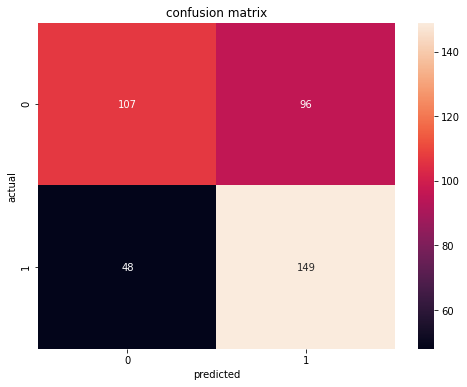

In [72]:
y2_score, y2_true, y2_hat = eval_MT_model(model, criterion1, criterion2, threshold = 0.5, eval_set = 'test')

### Visualize the saliency map

In [81]:
print(X_test['Img_path'][:5], y_test['JSL_Prog'].tolist()[:5])

3476    /content/drive/MyDrive/OAI_data/complete_images/9747589_2.png
85      /content/drive/MyDrive/OAI_data/complete_images/9072758_2.png
3992    /content/drive/MyDrive/OAI_data/complete_images/9926602_2.png
3275    /content/drive/MyDrive/OAI_data/complete_images/9677193_2.png
1513    /content/drive/MyDrive/OAI_data/complete_images/9066155_2.png
Name: Img_path, dtype: object [0.0, 1.0, 0.0, 0.0, 0.0]


0.06473244726657867


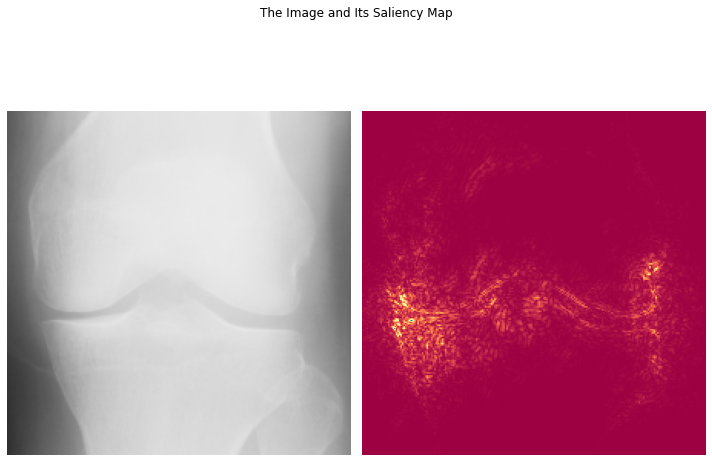

In [79]:
from PIL import Image

# Open the image file
image = Image.open('/content/drive/MyDrive/OAI_data/complete_images/9926602_2.png')

# Set up the transformations
transform_ = transforms.Compose([
		#transforms.Resize((256, 256)),
        #transforms.CenterCrop((130, 256)),
        transforms.Resize((224, 224)),
		transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transforms the image
image = transform_(image)
image = image.reshape(1, 3, 224, 224).to(device)
image.requires_grad_()

model_ft.eval()
y1, y2 = model_ft(image)
sigmoid = nn.Sigmoid()
print(sigmoid(y2).item())

# Catch the output
# Do backpropagation to get the derivative of the output based on the image
y2.backward()
saliency, _ = torch.max(image.grad.data.abs(),dim=1)

saliency = saliency.reshape(224, 224)

# Reshape the image
image = image.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2, figsize = (10, 8))
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0), cmap =  'RdGy')
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap =  'Spectral')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [80]:
#save model weights
PATH = '/content/drive/MyDrive/DL_models/multi_tasking_vgg.pt'
torch.save(model_ft.state_dict(), PATH)